In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import json
import pandas as pd
import seaborn as sns


In [2]:
# Plotting Helpers

from __future__ import division, print_function, absolute_import

import numpy as np
from matplotlib.colors import ColorConverter
from matplotlib import rcParams


__author__ = 'Felix Berkenkamp / Johannes Kirschner'
__all__ = ['set_figure_params', 'emulate_color', 'linewidth_in_data_units',
           'adapt_figure_size_from_axes', 'cm2inches', 'hide_all_ticks',
           'hide_spines', 'set_frame_properties']


def emulate_color(color, alpha=1, background_color=(1, 1, 1)):
    """Take an RGBA color and an RGB background, return the emulated RGB color.
    The RGBA color with transparency alpha is converted to an RGB color via
    emulation in front of the background_color.
    """
    to_rgb = ColorConverter().to_rgb
    color = to_rgb(color)
    background_color = to_rgb(background_color)
    return [(1 - alpha) * bg_col + alpha * col
            for col, bg_col in zip(color, background_color)]


def cm2inches(centimeters):
    """Convert cm to inches"""
    return centimeters / 2.54


def set_figure_params(serif=True):
    """Define default values for font, fontsize and use latex
    Parameters
    ----------
    serif: bool, optional
        Whether to use a serif or sans-serif font
    """

    params = {
              'font.family': 'serif',
              'font.serif': ['Times',
                             'Palatino',
                             'New Century Schoolbook',
                             'Bookman',
                             'Computer Modern Roman'],
              'font.sans-serif': ['Times',
                                  'Helvetica',
                                  'Avant Garde',
                                  'Computer Modern Sans serif'],
              'text.usetex': True,
#               'mathtext.fallback': 'stix',
              'mathtext.fontset' : 'stix',
              # Make sure mathcal doesn't use the Times style
              'text.latex.preamble':
              r' \usepackage{amssymb} \DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}',
              'axes.labelsize': 9,
              'axes.linewidth': .75,

              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,

              # 'figure.dpi': 150,
              # 'savefig.dpi': 600,
              # 'legend.numpoints': 1,
              }

    if not serif:
        params['font.family'] = 'sans-serif'

    rcParams.update(params)


def hide_all_ticks(axis):
    """Hide all ticks on the axis.
    Parameters
    ----------
    axis: matplotlib axis
    """
    axis.tick_params(axis='both',        # changes apply to the x-axis
                     which='both',       # affect both major and minor ticks
                     bottom='off',       # ticks along the bottom edge are off
                     top='off',          # ticks along the top edge are off
                     left='off',         # No ticks left
                     right='off',        # No ticks right
                     labelbottom='off',  # No tick-label at bottom
                     labelleft='off')    # No tick-label at bottom


def hide_spines(*axes, top=True, right=True, left=False):
    
    for axis in axes:
        """Hide the top and right spine of the axis."""
        if top:
            axis.spines['top'].set_visible(False)
            axis.xaxis.set_ticks_position('bottom')
        if right:
            axis.spines['right'].set_visible(False)
            axis.yaxis.set_ticks_position('left')
        if left:
            axis.spines['left'].set_visible(False)
            axis.yaxis.set_ticks([])


def set_frame_properties(axis, color, lw):
    """Set color and linewidth of frame."""
    for spine in axis.spines.values():
        spine.set_linewidth(lw)
        spine.set_color(color)


def linewidth_in_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.
    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.
    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()

    if reference == 'x':
        # width of the axis in inches
        axis_length = fig.get_figwidth() * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        axis_length = fig.get_figheight() * axis.get_position().height
        value_range = np.diff(axis.get_ylim())

    # Convert axis_length from inches to points
    axis_length *= 72

    return (linewidth / value_range) * axis_length


def adapt_figure_size_from_axes(axes):
    """
    Adapt the figure sizes so that all axes are equally wide/high.
    When putting multiple figures next to each other in Latex, some
    figures will have axis labels, while others do not. As a result,
    having the same figure width for all figures looks really strange.
    This script adapts the figure sizes post-plotting, so that all the axes
    have the same width and height.
    Be sure to call plt.tight_layout() again after this operation!
    This doesn't work if you have multiple axis on one figure and want them
    all to scale proportionally, but should be an easy extension.
    Parameters
    ----------
    axes: list
        List of axes that we want to have the same size (need to be
        on different figures)
    """
    # Get parent figures
    figures = [axis.get_figure() for axis in axes]

    # get axis sizes [0, 1] and figure sizes [inches]
    axis_sizes = np.array([axis.get_position().size for axis in axes])
    figure_sizes = np.array([figure.get_size_inches() for figure in figures])

    # Compute average axis size [inches]
    avg_axis_size = np.average(axis_sizes * figure_sizes, axis=0)

    # New figure size is the average axis size plus the white space that is
    # not begin used by the axis so far (e.g., the space used by labels)
    new_figure_sizes = (1 - axis_sizes) * figure_sizes + avg_axis_size

    # Set new figure sizes
    for figure, size in zip(figures, new_figure_sizes):
        figure.set_size_inches(size)
        
def plot_errorbars(axis, x, y, err, num=10, sigma=2, **kwargs):
    T = len(y)

    if axis.get_xscale() == 'log':
        l,h = x[0], x[-1]
        a = (h/l)**(1/num)
        b = np.log(l)/np.log(a)
        pos = np.power(a, np.linspace(b, b+num, num))
        pos = (pos - pos[0])/pos[-1]
        pos = np.floor(pos*np.linspace(1, len(x)-1, num=num)).astype(int)
        
        xpos = x[pos]
        ypos = y[pos]
        width = sigma*err[pos]
    else:
        pos = np.floor(np.linspace(0, len(x)-1, num=num)).astype(int)
        xpos = x[pos]
        ypos = y[pos]
        width = sigma*err[pos]
    
    axis.errorbar(xpos, ypos, width, 
                  ecolor=emulate_color('black', alpha=0.6),
                     capsize=2,
                     capthick=0.3,
                     elinewidth=0.3,
                     linewidth=0.6,
                     fmt="none",
                     errorevery=1,
                     **kwargs)
def shift_axis(ax, x):
    """ shift a subplot axis ax by x"""
    pos = ax.get_position()
    points = pos.get_points()
    points[:,0] += x
    pos.set_points(points)
    ax.set_position(pos)
def permute_list(lst, perm):
    new_list = []
    for i in perm:
        new_list.append(lst[i])
    return new_list

In [3]:
def load_data(env_path, basedir, sort_fct=None, final_only=False, verbose=False):
    """ helper function to load aggregated data """
    data = dict()
    extra_data = dict()
    env = None
    
    for path in glob.iglob(os.path.join(basedir, env_path, '*/'), recursive=False):
        strategy = path.rsplit(os.sep, maxsplit=3)[2]
        env = path.rsplit(os.sep, maxsplit=3)[1]
        env, horizon = env.split('-')
        horizon = int(horizon)
        
#         print(env, strategy)

        strategy_dict = dict()
    
        extra_files = [os.path.split(f)[1] for f in glob.iglob(path + 'extra-*.csv')]
        if len(extra_files) > 0:
            extra_data[strategy] = []
            for file in extra_files:
                df = pd.read_csv(os.path.join(path, file))
                extra_data[strategy].append(df)

        
        # get all files that where created for regret aggregation, there might be multiple
        aggr_files = [os.path.split(f)[1] for f in glob.iglob(path + 'aggr-*.csv')]
#         print(aggr_files)
        
        if len(aggr_files) == 0:
            continue
            
        with open(os.path.join(path, 'params.json')) as json_file:
            args = json.load(json_file)
        
        name = strategy.split('-')[0]
        strategy_dict['args'] = args
        strategy_dict['algorithm'] = name
        strategy_dict['env'] = env
        strategy_dict['n'] = horizon
        args_str = ','.join(f"{k}={v}" for k,v in args.items())
        strategy_dict['algorithm_args'] = f"{name}-{args_str}"
                                                        
        # find different aggregators and use the largest one
        aggr_dict = {}
        count = 0
        for file in aggr_files:
            _, aggr, count = file.split('-')
            count = int(count[:-4])  # shave of '.csv' suffix
            if aggr_dict.get(aggr, (0, None))[0] < count:
                aggr_dict[aggr] = count, file
                        
        for aggr, (count, file) in aggr_dict.items():
            # store data
#             print(f"{name}: reading {file} with {count} runs.")
            if verbose:
                print(f"{name}: {count} runs.")

            if final_only:
                strategy_dict[aggr] = pd.read_csv(os.path.join(path, file), delimiter=" ", header=None).values[-2:-1]
            else:
                strategy_dict[aggr] = pd.read_csv(os.path.join(path, file), delimiter=" ", header=None).values

#             strategy_dict[aggr] = np.loadtxt(os.path.join(path, file))
        strategy_dict['repetitions'] = count
        
        data[strategy] = strategy_dict
    if sort_fct is None:
        data = {k : v for k,v in sorted(data.items(), key=lambda i: i[1]['algorithm_args']) }
    else:
        data = {k : v for k,v in sorted(data.items(), key=sort_fct) }
    print(f"Loaded {len(data)} algorithms.")
    return env, data, extra_data

In [4]:
def plot_regret(data, axis, style_fct=None, exclude_fct=None, scale_fct=None, n=None, n0=0, sigma=2., every=1):
    color_idx = 0
    lines = []
    i = 0
    for strategy, strategy_data in data.items():
        if exclude_fct is not None and exclude_fct(strategy_data):
            continue

        regret = strategy_data['regret']
        if n is None:
            n = strategy_data['n']
        x=np.arange(0, n)
        rep = strategy_data['repetitions']
        
        # get styles
        if style_fct is None:
            styles = dict(color=COLORS[i], label=strategy)
        else:
            styles = style_fct(strategy_data, i)
        
        scale = 1.
        if scale_fct is not None:
            scale = scale_fct(strategy_data)
        
        mean = regret[n0:n:every, 0]
        err = sigma*regret[n0:n:every, 1]/np.sqrt(rep)
        lines.append(axis.plot(scale*x[n0:n:every], mean, **styles))
        print(strategy)
        axis.fill_between(scale*x[n0:n:every], mean - err, mean + err, color=styles['color'], alpha=0.2, linewidth=0.)
   
#         plot_errorbars(axis, x, , regret[n0:n, 1]/np.sqrt(rep), num=10, sigma=2)

        
        i += 1
    return lines

# Configuration

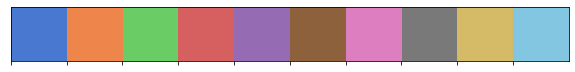

In [5]:
TEXTWIDTH = 4.56783
PLOTDIR = '/home/johannes/Documents/PhD/thesis/figures'
GOLDEN = 1.618
COLORS = sns.color_palette("muted")
sns.palplot(COLORS)

In [23]:
t_IDS = r"\textsc{IDS}"
t_BIDS = r"\textsc{Bayes-IDS}"
t_UCB = r"\textsc{UCB}"
t_GPUCB = r"\textsc{GPUCB}"
t_IUCB = r"$I^{UCB}$"
t_IDET = r"$I^{DET}$"
t_IAUCB = r"$I^{A-UCB}$"
t_IAWC = r"$I^{A}$"
t_IACELL = r"$I^{A-CELL}$"
t_IAUCBCELL = r"$I^{A-UCB-CELL}$"
t_IVAR = r"$I^{VAR}$"
t_IPM = r"$I^{PM}$"
t_SDIRAC = r"\textsc{Dirac}"
t_SFAST = r"\textsc{Fast}"
t_SFULL = r"\textsc{Exact}"
t_REGRET = r"$\mathfrak{R}_n$"

In [7]:
# only_logdet = True

def exclude_fct(strategy_data):
    """ exclude specific runs from plotting """
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
#     if algorithm == 'IDS':
#         if args['ids_sampling'] != 'fast':
#             return True

#     if args.get('delta'):
#         return True
    
#     if not args.get('normalize_actions'):
#         return True
    if algorithm == 'IDS' and \
        not (args.get('ids_info') == 'UCBInfoGain' and args.get('ids_gap') == 'FastValueGap'):
        return True
    return False


STYLES = {
    'IDS' : {
        'UCBInfoGain' : dict(label=f'{t_IDS}-{t_IUCB}', color=COLORS[0]),
        'WorstCaseInfoGain' : dict(label=f'{t_IDS}-{t_IDET}', color=COLORS[1]),
        'AsymptoticInfoGain-worst_case' : dict(label=f'{t_IDS}-{t_IAWC}', color=COLORS[1]),
        'AsymptoticInfoGain-ucb' : dict(label=f'{t_IDS}-{t_IAUCB}', color=COLORS[0]),
        'VarInfoGain' : dict(label=f'{t_BIDS}-{t_IVAR}', color=COLORS[3]),
        'DirectedInfoGain' : dict(label=f'{t_IDS}-{t_IPM}', color=COLORS[4]),
#         'UCBInfoGain' : dict(label='IDS-IUCB', color=COLORS[0]),
        'deterministic' : dict(linestyle=':'),
        'contextual' : dict(linestyle=':'),
        'fast' : dict(linestyle='-.'),
        'full' : dict(linestyle='-')
    },
    'AsymptoticIDS' : { 
        True : dict(label=f'{t_IDS}-{t_IAUCB}', color=COLORS[0]),
        False : dict(label=f'{t_IDS}-{t_IAWC}', color=COLORS[1]),
    },
    'DuelingKernelIDS' : dict(label=f'{t_IDS}-DUEL', color=COLORS[1]),
    'DuelingIDS' : dict(label=f'{t_IDS}-DUEL', color=COLORS[1]),
    'UCB' : dict(label=t_UCB, color=COLORS[2]),
    'GPUCB' : dict(label=t_UCB, color=COLORS[2]),
    'Solid-False' : dict(label='SOLID', color=COLORS[5]),
    'Solid-True' : dict(label='SOLID++', color=COLORS[5], linestyle='-.'),
    'TS' : dict(label=r'\textsc{TS}', color=COLORS[4]),
    'SemiparametricTS' : dict(label='Semi-TS', color=COLORS[7], linestyle=':'),

    'GCB' : dict(label=r'\textsc{GCB}', color=COLORS[6]),
    'Bose' : dict(label=r'\textsc{BOSE}', color=COLORS[6], linestyle=':'),

    'PEGE-log' : dict(label=r'\textsc{PEGE-log}', color=COLORS[7], linestyle=':'),
    'PEGE-worst_case' : dict(label=r'\textsc{PEGE-wc}', color=COLORS[7]),
    'MaxInP': dict(label='MaxInP', color=COLORS[8], linestyle='-.'),
}


def style_fct(strategy_data, i):
    """ read data for strategy and return a label. By default, returns the algorithm name. """
    label = strategy_data['algorithm']
    args = strategy_data['args']
    style = dict()
    if label == 'IDS':
        info = args['ids_info']
        if info == "AsymptoticInfoGain":
            info+= f"-{args['ids_info_correction']}"
        style.update(STYLES['IDS'][info])
        style.update(STYLES['IDS'][args['ids_sampling']])
        if args['ids_sampling'] == 'contextual':
            label += r"\textsc{FW}" + fr"-{args['ids_fw_steps']}"
    elif label == 'AsymptoticIDS':  # legacy naming
        style.update(STYLES[label][args['opt2']])
    elif label == 'Solid' :
        label += f"-{args['solid_opt']}"
        style.update(STYLES[label])
    elif label == 'PEGE':
        label += f"-{args['pege_mode']}"
        style.update(STYLES[label])
    else:
        style.update(STYLES[label])
    
    if label == 'UCB' and args.get('ucb_force_homoscedastic'):
        style['label'] = f'{t_UCB} (homosc.)'
        style['linestyle']  = ':'
        
    return style

def scale_fct(strategy_data):
    algo = strategy_data['algorithm']
    args = strategy_data['args']
    if args.get('to_dueling') == 'two':
        return 2.
    
    return 1.

# Chapter 3

## Noise Benchmark

In [33]:
basedir = '../../runs-thesis/3/'
exp_name = "noise_example-1000"
env, data, extra_data = load_data(exp_name, basedir=basedir)

Loaded 108 algorithms.


In [34]:
def filter_ids_worst_case(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return algorithm == 'IDS' and args.get('ids_info') == 'WorstCaseInfoGain'

def filter_ids_ucb(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return algorithm == 'IDS' and args.get('ids_info') == 'UCBInfoGain'

def filter_ucb(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return algorithm == 'UCB'

def exclude_rho_eps(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return not (args['noise_example_eps']==0.4 and args['noise_example_rhoi']==0.2)

def get_noise_example_data(data, filter_fct, d):
    final_regret = -np.ones((d+1, d+1))
    for strategy, strategy_data in data.items():
        if not filter_fct(strategy_data):
            continue

        args = strategy_data['args']
        regret = strategy_data['regret'][-1][0]
        eps = args['noise_example_eps']
        rhoi = args['noise_example_rhoi']
        
        eps, rhoi = (int(eps*d), int(rhoi*d))
        if final_regret[eps, rhoi] >= 0:
            raise RuntimeError("Filter function does not yield unique algorithm")
        final_regret[eps, rhoi] = regret
    return final_regret

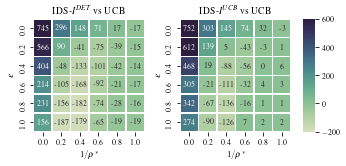

In [36]:
ucb_regret = get_noise_example_data(data, filter_fct=filter_ucb, d=5)
ids_wc_regret = get_noise_example_data(data, filter_fct=filter_ids_worst_case, d=5)
ids_ucb_regret = get_noise_example_data(data, filter_fct=filter_ids_ucb, d=5)

fig, (ax2, ax_empty, ax1, ax3)= plt.subplots(ncols=4, figsize=(0.95*TEXTWIDTH,TEXTWIDTH/2.2), 
                                   gridspec_kw={'width_ratios': [1, 0.1, 1, 0.1]})

ticks = [i/5 for i in range(6)]
ids_ucb_relative = ucb_regret - ids_ucb_regret
ids_wc_relative = ucb_regret - ids_wc_regret
ids_wc_ucb = ids_ucb_regret - ids_wc_regret

heatmap_kw = dict(
    linewidth=0.5,
    vmin=-200, 
    vmax=600, 
#     cmap=sns.color_palette("crest", as_cmap=True),
    cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
    fmt='g',
    xticklabels=ticks,
    yticklabels=ticks
)
sns.heatmap(ids_ucb_relative,  ax=ax1, cbar=False, annot=np.round(ids_ucb_relative), **heatmap_kw, )
sns.heatmap(ids_wc_relative, ax=ax2, cbar=True, cbar_ax=ax3, annot=np.round(ids_wc_relative), **heatmap_kw)
# sns.heatmap(ids_wc_ucb, linewidth=0.5, ax=ax3, vmin=vmin, vmax=vmax, cmap=cmap, annot=np.round(ids_wc_ucb),fmt='g')


for ax in (ax1, ax2):
    ax.set_ylabel(r'$\epsilon$')
    ax.set_xlabel(r'$1/\rho^*$')
ax_empty.axis('off')

set_figure_params()
fig.subplots_adjust(left=0.)
ax1.set_title(f"{t_IDS}-{t_IUCB} vs {t_UCB}")
ax2.set_title(f"{t_IDS}-{t_IDET} vs {t_UCB}")

# fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'linear', 'noise_example.pdf',), bbox_inches='tight', pad_inches=0.10)

## Env C

In [19]:
basedir = '../../runs-thesis/3/'
exp_name = "2018_heteroscedastic_c-5000"
env, data, extra_data = load_data(exp_name, basedir=basedir)

Loaded 16 algorithms.


IDS-43a831d2e75d96fc17320628d08d200b
IDS-511d3362152e3dae84e899bbd455b680
IDS-14ebe2d68273e7d1e516d10f204c799b
IDS-a37721a4636dfdb7fb361b53727cc951
IDS-41205272fcda1255b63f2fe2e11530a9
IDS-d9f1a5060fe4133718ab0803aedeec96
UCB-053b3bb8a97828d88986ea3270132343
UCB-48caeeceda1ee2e53da8c7e9174a6317
IDS-c99373475006f8d7c7bd493286590732
IDS-94eb3aed1cdd251999fbfd4a40b8722c
IDS-42c30078dc9edfafdbaeb917b23ceeba
IDS-a367e7092b4c60f36a46eb21cd1a9391
IDS-0153e7050a0a7f0c142a94b7928b3f44
IDS-c89247ff71e0870a1f4c2b211a0e9592
UCB-5c8d51920f6c042fa223d8b23dc08051
UCB-02447c291649d114316b160d576d625c


/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


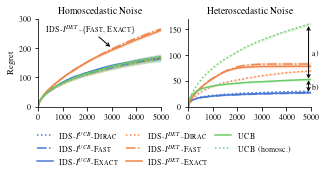

In [24]:
# two per figure plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.5))


def homoscedastic_only(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return not args['env_force_homoscedastic']

def heteroscedastic_only(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return args['env_force_homoscedastic']

def style_mod(strategy_data, i):
    styles = style_fct(strategy_data, i)
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm == 'IDS':
        if args['ids_sampling'] == 'deterministic':
            styles['label'] = styles['label'] +f'-{t_SDIRAC}'
        if args['ids_sampling'] == 'full':
            styles['label'] = styles['label'] +f'-{t_SFULL}'
        if args['ids_sampling'] == 'fast':
            styles['label'] = styles['label'] +f'-{t_SFAST}'
    return styles

# plot first axis
plot_regret(data, ax1,  exclude_fct=homoscedastic_only, style_fct=style_mod)
ax1.set_ylabel('Regret')
# ax1.legend(loc="upper left")

lines = plot_regret(data,  ax2, exclude_fct=heteroscedastic_only,  style_fct=style_mod)
# ax2.set_ylabel('Regret')

lgd = fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.3),# Small spacing around legend box
           ncol=3,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )
ax1.set_title("Homoscedastic Noise")
ax2.set_title("Heteroscedastic Noise")
for ax in (ax1, ax2):
    ax.set_xlim(0,5000)

ax1.set_ylim(0,300)
ax2.set_ylim(0,170)


ax1.annotate(f"{t_IDS}-{t_IDET}-" + "\{" + f"{t_SFAST}, {t_SFULL}" +"\}", xy=(3000,200),  xytext=(300, 250),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='bottom')
ax2.annotate(text='', xy=(4900,50), xytext=(4900,160), arrowprops=dict(arrowstyle='<->'))
ax2.text(5050, 100, 'a)')
ax2.annotate(text='', xy=(4900,25), xytext=(4900,55), arrowprops=dict(arrowstyle='<->'))
ax2.text(5050, 35, 'b)')



set_figure_params()
hide_spines(ax1, ax2)
fig.subplots_adjust()
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'linear', 'env_c.pdf',), bbox_inches='tight', pad_inches=0.00)

# Chapter 5

## Tuning beta

In [1077]:
basedir = '../../runs-thesis/5/tuned/'
exp_name = "simple_bandit_d2_k6_v0.1-10000"
_, data1d, _ = load_data(exp_name, basedir=basedir)

basedir = '../../runs-thesis/5/tuned2/'
exp_name = "simple_bandit_d2_k6_v0.1-10000"
_, data2d, _ = load_data(exp_name, basedir=basedir)

out5tuning = 'random'

# basedir = '../../runs-thesis/5/tuned/'
# exp_name = "simple_bandit_d2_k6_v10.0-10000"
# _, data1d, _ = load_data(exp_name, basedir=basedir)

# basedir = '../../runs-thesis/5/tuned2/'
# exp_name = "simple_bandit_d2_k6_v10.0-10000"
# _, data2d, _ = load_data(exp_name, basedir=basedir)

# out5tuning = 'randomv10'

# basedir = '../../runs-thesis/5/tuned/'
# exp_name = "simple_bandit_d2_k6_v1.0-10000"
# _, data1d, _ = load_data(exp_name, basedir=basedir)

# basedir = '../../runs-thesis/5/tuned2/'
# exp_name = "simple_bandit_d2_k6_v1.0-10000"
# _, data2d, _ = load_data(exp_name, basedir=basedir)

# out5tuning = 'randomv1'


basedir = '../../runs-thesis/5/tuned/'
exp_name = "counter_example_v0.1_e0.01_a0.5-1000000"
_, data1d, _ = load_data(exp_name, basedir=basedir, final_only=True)

basedir = '../../runs-thesis/5/tuned2/'
exp_name = "counter_example_v0.1_e0.01_a0.5-1000000"
_, data2d, _ = load_data(exp_name, basedir=basedir, final_only=True)

out5tuning = 'eoo'

Loaded 18 algorithms.
Loaded 72 algorithms.
Loaded 18 algorithms.
Loaded 72 algorithms.


In [1078]:
# basedir = '../../runs-thesis/5/tuned/'
# exp_name = "counter_example_v0.1_e0.01_a0.5-1000001"
# _, dataeta, _ = load_data(exp_name, basedir=basedir, final_only=True)

In [1079]:
def filter_ids_worst_case(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return algorithm == 'IDS' and args.get('ids_info_correction') == 'worst_case'

def filter_ids_ucb(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return algorithm == 'IDS' and args.get('ids_info_correction') == 'ucb'

def filter_ucb(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return algorithm == 'UCB'

def exclude_rho_eps(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    return not (args['noise_example_eps']==0.4 and args['noise_example_rhoi']==0.2)

def get_final_regret_1d(data, filter_fct, return_dict=False, field='lls_beta'):
    final_regret = dict()
    
    for strategy, strategy_data in data.items():
        if not filter_fct(strategy_data):
            continue

        args = strategy_data['args']
        regret = strategy_data['regret'][-1][0]
        beta = args[field]
#         rhoi = args['noise_example_rhoi']
        
        if beta in final_regret:
            raise RuntimeError("Filter function does not yield unique algorithm")
        final_regret[beta] = regret
    if return_dict:
        return final_regret, None
    beta = sorted([*final_regret.keys()])
    final_regret = np.array([v for k, v in sorted(final_regret.items(), key=lambda x: x[0])])
    return final_regret.reshape(-1,1), beta


def get_final_regret_2d(data, filter_fct, return_dict=False):
    final_regret = dict()
    
    for strategy, strategy_data in data.items():
        if not filter_fct(strategy_data):
            continue

        args = strategy_data['args']
        regret = strategy_data['regret'][-1][0]
        beta = args['lls_beta']
        eta = args['ids_eta']
        
        if not beta in final_regret:
            final_regret[beta] = dict()
#         rhoi = args['noise_example_rhoi']
        
        if eta in final_regret[beta]:
            raise RuntimeError("Filter function does not yield unique algorithm")
        final_regret[beta][eta] = regret
    
    if return_dict:
        return final_regret, None, None
    # inner sort
    primary = sorted([*final_regret.keys()])
    secondary = sorted([*final_regret[primary[0]].keys()])
    for key in final_regret.keys():
        final_regret[key] = np.array([v for k, v in sorted(final_regret[key].items(), key=lambda x: x[0])])
    final_regret = np.array([v for k, v in sorted(final_regret.items(), key=lambda x: x[0])])

    return final_regret, primary, secondary

get_final_regret_1d(data1d, filter_ids_worst_case)

(array([[ 16.6914],
        [ 30.2988],
        [ 62.8216],
        [129.6068],
        [255.5029],
        [506.4309]]), [1.0, 2.0, 4.0, 8.0, 16.0, 32.0])

In [1080]:
return_dict=False
ids_wc_2d, beta, eta = get_final_regret_2d(data2d, filter_fct=filter_ids_worst_case, return_dict=return_dict)
ids_ucb_2d, beta, eta = get_final_regret_2d(data2d, filter_fct=filter_ids_ucb, return_dict=return_dict)
ids_wc_1d, beta = get_final_regret_1d(data1d, filter_fct=filter_ids_worst_case, return_dict=return_dict)
ids_ucb_1d, beta = get_final_regret_1d(data1d, filter_fct=filter_ids_ucb, return_dict=return_dict)
ucb_1d, beta = get_final_regret_1d(data1d, filter_fct=filter_ucb, return_dict=return_dict)

# ucb_1d, ids_ucb_1d, ids_wc_1d
# ids_wc_2d, ids_ucb_2d

In [1081]:
# get_final_regret_1d(dataeta, filter_fct=filter_ids_worst_case, field='ids_eta')

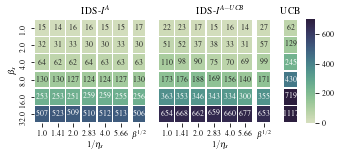

In [1082]:
ratio_1d = 0.15
fig, axes = plt.subplots(ncols=6, figsize=(TEXTWIDTH*0.95,TEXTWIDTH/2.4), 
                                   gridspec_kw={'width_ratios': [1,ratio_1d, 1, ratio_1d,ratio_1d, 0.1]})
ax1, ax3, ax2, ax4, ax5, ax_bar = axes


VMAX=dict(eoo=700,random=200,randomv1=400,randomv10=500)
vmax = VMAX[out5tuning]
heatmap_kw = dict(
    linewidth=0.5,
    vmin=0, 
    vmax=vmax, 
#     cmap=sns.color_palette("crest", as_cmap=True),
    cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
    fmt='g',
    xticklabels=eta,
    yticklabels=beta)
sns.heatmap(ids_wc_2d,  ax=ax1, cbar=False, annot=np.round(ids_wc_2d), **heatmap_kw)
heatmap_kw['yticklabels'] = False

sns.heatmap(ids_ucb_2d, ax=ax2, cbar=True, cbar_ax=ax_bar, annot=np.round(ids_ucb_2d), **heatmap_kw)

heatmap_kw['xticklabels'] = [r'$\beta^{1/2}$']
sns.heatmap(ids_wc_1d, ax=ax3, cbar=False, annot=np.round(ids_wc_1d), **heatmap_kw)
sns.heatmap(ids_ucb_1d, ax=ax4, cbar=False, annot=np.round(ids_ucb_1d), **heatmap_kw)
# UCB
heatmap_kw['xticklabels'] = False
sns.heatmap(ucb_1d, ax=ax5, cbar=False, annot=np.round(ucb_1d), **heatmap_kw)

# sns.heatmap(ids_wc_ucb, linewidth=0.5, ax=ax3, vmin=vmin, vmax=vmax, cmap=cmap, annot=np.round(ids_wc_ucb),fmt='g')

ax1.set_ylabel(r'$\beta_s$')
for ax in (ax1, ax2):
    ax.set_xlabel(r'$1/\eta_s$', x=0.65)
ax_empty.axis('off')

set_figure_params()
fig.subplots_adjust(left=0.)
ax1.set_title(f"{t_IDS}-{t_IAWC}", x=0.65)
ax2.set_title(f"{t_IDS}-{t_IAUCB}", x=0.65)
# ax3.set_title("IDS(DET)")
# ax4.set_title("IDS(UCB)")
ax5.set_title(t_UCB)
# ax3.set_position([0,0,0,0])
shift_axis(ax3, -0.015)
shift_axis(ax4, -0.015)


fig.savefig(os.path.join(PLOTDIR, 'asymptotics', f'tuning_{out5tuning}.pdf',), bbox_inches='tight', pad_inches=0.10)

## Random & EOO (COLT)

In [1007]:
basedir = '../../runs-colt2021-final/'
exp_name = "simple_bandit_v0.1-1000000"
env, data_sb, extra_data = load_data(exp_name, basedir=basedir)

exp_name = "counter_example_v0.1_e0.01_a0.5-1000000"
env, data_eoo, extra_data = load_data(exp_name, basedir=basedir)

Loaded 11 algorithms.
Loaded 11 algorithms.


AsymptoticIDS-b2c5dc9ff796e860e40d581560e275e9
AsymptoticIDS-857765119c7ccebb52b414a90ba7873d
Solid-1d405251592737ce6dada92987a899a8
Solid-324d4c4dd0978478d40625aae3ef8a5f
UCB-c8e0d8c0efa2aee6b40ba0e261d53fe9
AsymptoticIDS-b2c5dc9ff796e860e40d581560e275e9
AsymptoticIDS-857765119c7ccebb52b414a90ba7873d
Solid-1d405251592737ce6dada92987a899a8
Solid-324d4c4dd0978478d40625aae3ef8a5f
UCB-c8e0d8c0efa2aee6b40ba0e261d53fe9


/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


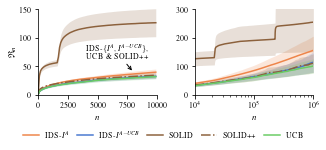

In [1040]:
# two per figure plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.5))

env = 'eoo'
env = 'sb'

if env == 'eoo':
    data = data_eoo
else:
    data = data_sb
    

def exclude_fct(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if algorithm == 'Solid' and args.get('solid_z0')==100:
        return True
    if algorithm == 'TS':
        return True
    if algorithm == 'AsymptoticIDS' and not args.get('ids_fast_info'):
        return True  # Cells vs Halfspaces
    

plot_regret(data, ax1,  exclude_fct=exclude_fct, style_fct=style_fct, every=100, n0=0, n=10000)
lines = plot_regret(data, ax2,  exclude_fct=exclude_fct, style_fct=style_fct, every=100,n0=10000, n=1000000)

ax1.set_xlim(0, 10000)
ax2.set_xlim(10000, 1000000)

if env == 'eoo':
    ax1.set_ylim(0, 50)
    ax1.annotate(f"{t_IDS}-{t_IAUCB} \& {t_UCB}", xy=(8000,22), 
                 xytext=(3000, 40),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='bottom')

else:
    ax1.set_ylim(0,150)
    ax2.set_ylim(0,300)
    ax1.annotate(f"{t_IDS}-" + "\{" + fr"{t_IAWC}, {t_IAUCB}" +"\}," + "\n" + fr"{t_UCB}" + r" \& \textsc{SOLID++}", xy=(8000,40), 
                 xytext=(4000, 60),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='bottom')

    


ax2.set_xscale("log")
ax1.set_ylabel(t_REGRET)
for ax in (ax1, ax2):
    ax.set_xlabel('$n$')

# if env == 'eoo':
#     ax1.set_title("Random Action Sets")
# else:
#     ax1.set_title("End of Optimism")

lgd = fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.1),# Small spacing around legend box
           ncol=5,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )

set_figure_params()
hide_spines(ax1, ax2)
fig.subplots_adjust()
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'asymptotics', f"{env}.pdf",), bbox_inches='tight', pad_inches=0.00)

## Alternatives (COLT)

In [17]:
basedir = '../../runs-thesis/5/cell/'
exp_name = "simple_bandit_d2_k6_v0.1-1000000"
env, data_sb, extra_data = load_data(exp_name, basedir=basedir)

exp_name = "counter_example_v0.1_e0.01_a0.5-1000000"
env, data_eoo, extra_data = load_data(exp_name, basedir=basedir)

Loaded 7 algorithms.
Loaded 7 algorithms.


IDS-02a7fe94b98f6159bbc1c80caf14d973
IDS-daa613aecf5ba8fd35c25a94e6fc18a4
IDS-93eb406ec6ca895149b87896bc561b6a
IDS-23ba8212079dff87bdd35a794e77847d
IDS-09f761a58991ce1ba2d16290ca4ec657
IDS-0bf955ecabf35f570a34efcf1d6ebd17
UCB-5183b355dd73a86d1b6b36195a139578
IDS-3590e8330fc88fb5675f14beec539838
IDS-3223df682f44bda7de8100292fd41a32
IDS-63bfd0778f74730721993040f4e989c0
IDS-ebb3a38bbb5ce5d64b94af5eb6d9ccac
IDS-69dc8c40335f6e18e7a5ef65ff90343f
IDS-cf4552bd3072bbb2bcda9153c2c71f85
UCB-8de26bc3bb941fc38c4ab1306033ddd8


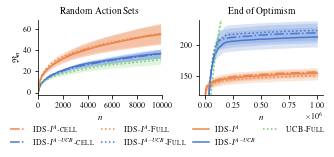

In [18]:
# two per figure plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.5))


def exclude_fct(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
#     if algorithm == 'Solid' and args.get('solid_z0')==100:
#         return True
#     if algorithm == 'TS':
#         return True
#     if algorithm == 'AsymptoticIDS' and not args.get('ids_fast_info'):
#         return True  # Cells vs Halfspaces
    

def style_mod(strategy_data,i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
    if args.get('ids_sampling') == 'full':
        styles['label'] += fr'-{t_SFULL}'
        styles['linestyle'] = ':'
    elif args.get('ids_alternatives') == 'cell':
        styles['label'] += r'-\textsc{cell}'
        styles['linestyle'] = '-.'
    else:
        styles['linestyle'] = '-'
    return styles
plot_regret(data_sb, ax1,  exclude_fct=exclude_fct, style_fct=style_mod, every=100, n0=0, n=10000)
lines = plot_regret(data_eoo, ax2,  exclude_fct=exclude_fct, style_fct=style_mod, every=100)

# for ax in (ax1, ax2):
#     ax.set_xlim(n0,n)
#     if asymptotic:
#         ax.set_xscale("log")
#     else:
#         ax.set_ylim(0,150)

ax2.set_ylim(120, 240)
ax1.set_xlim(0, 10000)
ax1.set_ylabel(t_REGRET)

for ax in (ax1, ax2):
    ax.set_xlabel('$n$')

ax1.set_title("Random Action Sets")
ax2.set_title("End of Optimism")

handles, labels = ax1.get_legend_handles_labels()
handles = permute_list(handles, [1,0,5,3,4,2,6])
labels = permute_list(labels, [1,0,5,3,4,2,6])

lgd = fig.legend(handles,
           labels,
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.15),# Small spacing around legend box
           ncol=4,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )

set_figure_params()
hide_spines(ax1, ax2)
fig.subplots_adjust()
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'asymptotics', f"alternatives.pdf",), bbox_inches='tight', pad_inches=0.00)

## Bayesian & Runtime

In [8]:
basedir = '../../runs-thesis/5/bayes/'
exp_name = "simple_bandit_d2_k6_v0.1-100000"
env, data_sb, extra_data = load_data(exp_name, basedir=basedir)

exp_name = "counter_example_v0.1_e0.01_a0.5-100000"
env, data_eoo, extra_data = load_data(exp_name, basedir=basedir)

Loaded 9 algorithms.
Loaded 9 algorithms.


IDS
{'beta_asymptotic': False, 'beta_factor': 1.0, 'compensate': False, 'd': 2, 'env_force_homoscedastic': False, 'eoo_alpha': 1.0, 'eoo_eps': 0.01, 'game': 'simple_bandit', 'ids_alternatives': 'halfspace', 'ids_discard': False, 'ids_exploit': False, 'ids_gap': 'BayesianGap', 'ids_info': 'VarInfoGain', 'ids_info_correction': 'worst_case', 'ids_record_info': False, 'ids_sampling': 'fast', 'k': 6, 'laser_indirect': False, 'lb_return': False, 'lengthscale': 1.0, 'lls_scale_obs': True, 'n': 100000, 'noise_example_eps': 0.0, 'noise_example_rhoi': 1.0, 'noise_var': 0.1, 'normalize_actions': True, 'points_per_dim': 50, 'regularizer': 1.0, 'se_d': 2, 'solid_opt': False, 'solid_reset': False, 'solid_z0': 100, 'strategy': 'ids', 'ts_scale': 1.0, 'ucb_force_homoscedastic': False}
IDS
{'beta_asymptotic': False, 'beta_factor': 1.0, 'compensate': False, 'd': 2, 'env_force_homoscedastic': False, 'eoo_alpha': 1.0, 'eoo_eps': 0.01, 'game': 'simple_bandit', 'ids_alternatives': 'halfspace', 'ids_discard'

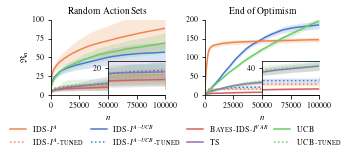

In [11]:
# two per figure plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.5))


def exclude_fct(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    # Bayesian Algorithms get real priors
    if algorithm == 'TS' or (algorithm == 'IDS' and args['ids_info'] == 'VarInfoGain'):
        if not args.get('lls_scale_obs'):
            return True
    if algorithm == 'IDS':
        if args['ids_info'] == 'VarInfoGain' and args['ids_sampling'] == 'fast':
            return True
#     if algorithm == 'IDS' and args['ids_info'] == 'AsymptoticInfoGain' and args['ids_info_correction'] == 'worst_case':
#         return True

    
def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
    if algorithm == 'UCB' and args.get('lls_beta'):
        styles['label'] = r'\textsc{UCB-tuned}'
        styles['linestyle'] = ':'
    if algorithm == 'IDS':
        if args.get('lls_beta'):
            styles['label']  += r'-\textsc{tuned}'
            styles['linestyle'] = ':'
        else:
            styles['linestyle'] = '-'
    return styles

 
plot_regret(data_sb, ax1,  exclude_fct=exclude_fct, style_fct=style_mod, every=100)
lines = plot_regret(data_eoo, ax2,  exclude_fct=exclude_fct, style_fct=style_mod, every=100)

for ax in (ax1, ax2):
    ax.set_xlabel(r'$n$')
    ax.set_xlim(0,100000)

ax1.set_ylabel(t_REGRET)
ax1.set_title("Random Action Sets")
ax2.set_title("End of Optimism")
ax1.set_ylim(0,100)
ax2.set_ylim(0,200)

ax1i= ax1.inset_axes([0.5, 0.0, 0.5, 0.45])
ax1i.set_xticklabels([])
ax1i.set_xticks([])
ax1i.set_xlim(50000, 100000)
ax1i.set_ylim(0, 25)
ax1i.set_yticks([20])
plot_regret(data_sb, ax1i,  exclude_fct=exclude_fct, style_fct=style_mod, every=100)

ax2i= ax2.inset_axes([0.5, 0.0, 0.5, 0.45])
ax2i.set_xticklabels([])
ax2i.set_xticks([])
ax2i.set_xlim(50000, 100000)
ax2i.set_ylim(0, 50)
ax2i.set_yticks([40])
plot_regret(data_eoo, ax2i,  exclude_fct=exclude_fct, style_fct=style_mod, every=100)


perm = [4,3,2,1,0,5,7,6]
handles, labels = ax1.get_legend_handles_labels()
handles = permute_list(handles, perm)
labels = permute_list(labels, perm)

lgd = fig.legend(handles,
           labels,
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.15),# Small spacing around legend box
           ncol=4,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )


set_figure_params()
hide_spines(ax1, ax2)
hide_spines(ax1i, ax2i, top=False)
fig.subplots_adjust()
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'asymptotics', f"bayesian.pdf",), bbox_inches='tight', pad_inches=0.00)

## Runtime

In [28]:
basedir = '../../runs-thesis-shallow/time/'
exp_name = "simple_bandit_d2_k6_v0.1-100000"
env, data_k6, extra_data = load_data(exp_name, basedir=basedir)
exp_name = "simple_bandit_d5_k50_v0.1-100000"
env, data_k50, extra_data = load_data(exp_name, basedir=basedir)



Loaded 8 algorithms.
Loaded 8 algorithms.


In [31]:
# table = ''
# for strategy, strategy_data in data.items():
#     table += f"{style_fct(strategy_data,0)['label']}" + ' & '

# table = table[:-2]
# table += '\\\\\n'
# for strategy, strategy_data in data.items():
#     table += f"${strategy_data['time'][0][0]:.1f}\pm{strategy_data['time'][0][1]:.1f}$" + ' & '

def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
    sampling = args.get('ids_sampling')
    if algorithm not in ['UCB', 'TS'] and sampling != 'full':
        styles['label'] += r'-\textsc{fast}'
    return styles

table = ''
for (s_k6, d_k6), (s_k50, d_k50) in zip(data_k6.items(), data_k50.items()):
    l_k6 = style_mod(d_k6,0)['label']
    l_k50 = style_mod(d_k50,0)['label']
    print(l_k6, l_k50)

    if l_k6 != l_k50:
        print("WARNING: ORDER NOT MATCHING")
    table += f"{l_k6}" + ' & ' +\
        f"${d_k6['time'][0][0]:.1f}$&$\pm{d_k6['time'][0][1]:.1f}$" + ' & ' +\
        f"${d_k50['time'][0][0]:.1f}$&$\pm{d_k50['time'][0][1]:.1f}$" + '\\\\\n '

print(table)

\textsc{Bayes-IDS}-$I^{VAR}$-\textsc{fast} \textsc{Bayes-IDS}-$I^{VAR}$-\textsc{fast}
\textsc{Bayes-IDS}-$I^{VAR}$ \textsc{Bayes-IDS}-$I^{VAR}$
\textsc{IDS}-$I^{DET}$-\textsc{fast} \textsc{IDS}-$I^{DET}$-\textsc{fast}
\textsc{IDS}-$I^{DET}$ \textsc{IDS}-$I^{DET}$
\textsc{IDS}-$I^{A-UCB}$-\textsc{fast} \textsc{IDS}-$I^{A-UCB}$-\textsc{fast}
\textsc{IDS}-$I^{A-UCB}$ \textsc{IDS}-$I^{A-UCB}$
\textsc{TS} \textsc{TS}
\textsc{UCB} \textsc{UCB}
\textsc{Bayes-IDS}-$I^{VAR}$-\textsc{fast} & $544.4$&$\pm69.7$ & $1771.9$&$\pm40.5$\\
 \textsc{Bayes-IDS}-$I^{VAR}$ & $561.7$&$\pm58.8$ & $2560.0$&$\pm78.4$\\
 \textsc{IDS}-$I^{DET}$-\textsc{fast} & $42.0$&$\pm9.7$ & $76.1$&$\pm19.6$\\
 \textsc{IDS}-$I^{DET}$ & $52.7$&$\pm11.6$ & $888.5$&$\pm75.6$\\
 \textsc{IDS}-$I^{A-UCB}$-\textsc{fast} & $45.7$&$\pm18.8$ & $106.8$&$\pm28.6$\\
 \textsc{IDS}-$I^{A-UCB}$ & $50.5$&$\pm22.6$ & $798.5$&$\pm233.5$\\
 \textsc{TS} & $21.6$&$\pm5.9$ & $22.2$&$\pm6.9$\\
 \textsc{UCB} & $26.9$&$\pm7.7$ & $23.9$&$\pm5.7$\\
 


## Infogain plot

/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


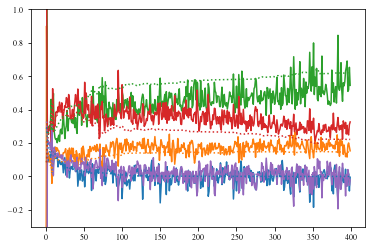

In [23]:
out = np.load('../infogain.npy')
info1 = out[0]
info2 = out[1]

def plot_info(info1, axis, linestyle='-'):
    for i,I in enumerate(info1.T):
        axis.plot(I, label=f"{i}", linestyle=linestyle, color=COLORS[2*i])
        
        
fig, axis = plt.subplots(1,1)

plot_info(info1, axis)

# info2 = 1/info2
# info2 = (info2.T / np.sum(info2, axis=1)).T
# print(info2[49])
plot_info(info2, axis, linestyle=':')
axis.set_ylim(-0.3,1)

fig.show()

In [669]:
basedir = '../../runs-thesis-shallow/info/'
exp_name = "simple_bandit_d3_k5_v1.0_s5-500"
# exp_name = "simple_bandit_d2_k4_v0.1_s1-10000"
# exp_name = "simple_bandit_d3_k5_v0.1_s2-10000"

exp_name = "counter_example_v0.1_e0.01_a0.5-2000"

# exp_name = "camelback-500"

env, data, extra_data = load_data(exp_name, basedir=basedir)
# extra_data
list(extra_data)[0]

Loaded 1 algorithms.


'IDS-1562e314f5fbad053add36ec0bde13f9'

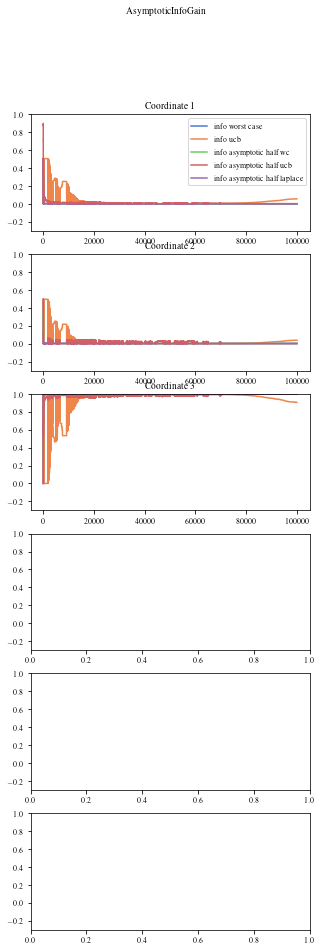

In [552]:
num = 1
rep = 1
def plot_info_gain(data, axes):
    d = len(axes)
    colors = dict()
    
    lines = []
    for col, col_data in data.items():
        name, coord = col.rsplit('_', maxsplit=1)
        if name in ['info_mi_sample', 'info_var']:
            continue
        if 'cell' in name: #or 'laplace' in name:
            continue
        coord = int(coord)
        if not name in colors:
            colors[name] = COLORS[len(colors)]
        
#         print(col_data)
#         print(colors[name])
        axes[coord].plot(col_data, color=colors[name], label=name.replace('_', ' '))
        axes[coord].set_title(f"Coordinate {coord + 1}")
        
    
    

fig, axes = plt.subplots(6, figsize=(5,15))

algo = list(extra_data)[num]
info_data = extra_data[algo][rep].to_dict(orient='list')
fig.suptitle(data[algo]['args']['ids_info'])
plot_info_gain(info_data, axes)
for axis in axes:
    axis.set_ylim(-0.3,1.)
#     axis.set_xlim(0,1000)
axes[0].legend()
fig.savefig(os.path.join('../../plots/thesis/', f'infogain_{num}_{rep}_{exp_name}.pdf',), bbox_inches='tight', pad_inches=0.00)

## InfoGain EOO

\textsc{IDS}-$I^{A}$
info_mi_sample
info_worst_case
info_worst_case=,
info_ucb
info_ucb=,
info_var
info_var=,
info_asymptotic_half_wc
info_asymptotic_half_ucb
info_asymptotic_half_wc_cell
info_asymptotic_half_wc_cell=,
info_asymptotic_half_ucb_cell
info_asymptotic_half_ucb_cell=,
info_asymptotic_half_laplace
info_mi_sample
info_worst_case
info_worst_case=,
info_ucb
info_ucb=,
info_var
info_var=,
info_asymptotic_half_wc
info_asymptotic_half_ucb
info_asymptotic_half_wc_cell
info_asymptotic_half_wc_cell=,
info_asymptotic_half_ucb_cell
info_asymptotic_half_ucb_cell=,
info_asymptotic_half_laplace
info_mi_sample
info_worst_case
info_worst_case=,
info_ucb
info_ucb=,
info_var
info_var=,
info_asymptotic_half_wc
info_asymptotic_half_ucb
info_asymptotic_half_wc_cell
info_asymptotic_half_wc_cell=,
info_asymptotic_half_ucb_cell
info_asymptotic_half_ucb_cell=,
info_asymptotic_half_laplace


/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


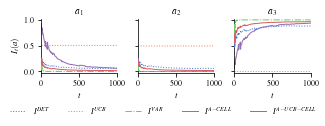

In [672]:
algo = list(extra_data)[0]
rep=1
info_data = extra_data[algo][rep].to_dict(orient='list')
print(style_fct(data[algo],0 )['label'])

fig, axes = plt.subplots(ncols=3, figsize=(TEXTWIDTH, TEXTWIDTH/3.))
(ax1, ax2, ax3) = axes

INFOLABELS = dict(
    info_worst_case=dict(label=t_IDET, linestyle=':', color=COLORS[0], zorder=10),
    info_ucb=dict(label=t_IUCB, linestyle=':', color=COLORS[1]),
    info_var=dict(label=t_IVAR, color=COLORS[2], linestyle='-.', zorder=10),
    info_asymptotic_half_wc_cell=dict(label=t_IACELL, color=COLORS[3], linestyle='-', zorder=10),
    info_asymptotic_half_ucb_cell=dict(label=t_IAUCBCELL, color=COLORS[4], linestyle='-', zorder=2),
#     info_asymptotic_half_laplace=dict(label=t_IAUCBCELL, color=COLORS[4], linestyle='-', zorder=2),
)


def plot_info_coord(axes, coord, data):
    d = len(axes)
    colors = dict()
    
    lines = []
    for col, col_data in data.items():
        name, _coord = col.rsplit('_', maxsplit=1)
        if int(_coord) != coord:
            continue
        print(name)
        if not name in INFOLABELS:
            continue
        coord = int(coord)
        if not name in colors:
            colors[name] = COLORS[len(colors)]
        print(f"{name}=,")
        
#         print(col_data)
#         print(colors[name])
        for ax in axes:
            lines.append(ax.plot(col_data, **INFOLABELS[name],linewidth=1.))
#         axes[coord].set_title(f"Coordinate {coord + 1}")
    return lines
plot_info_coord([ax1], 0, info_data)
plot_info_coord([ax2], 1, info_data)
lines = plot_info_coord([ax3], 2, info_data)


# ax1.set_xticks([0,50, 100])
hide_spines(*axes)

for ax in axes[1:]:
    ax.set_yticklabels([])
for i, ax in enumerate(axes):
    ax.set_ylim(-0.03,1.01)
    ax.set_xlim(-5,1000)
    ax.set_title(fr"$a_{i+1}$")
    ax.set_xlabel('$t$')
#     ax.set_xlabel('$t$', x=1, labelpad=-8)

    
ax1.set_ylabel(r'$I_t(a)$')

set_figure_params()

lgd = fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-.1),# Small spacing around legend box
           ncol=5,
           fancybox=False,
           frameon=False,
           columnspacing=2.5
          )
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'asymptotics', 'infogain_eoo.pdf',), bbox_inches='tight', pad_inches=0.00)

# Chapter 6

## Random Dueling

In [1041]:
basedir = '../../runs-thesis/6/'
exp_name = "random_dueling_d3_k20_v0.1-10000"
exp_name = "random_dueling_d2_k6_v0.1-10000"


env, data_dueling_random, extra_data = load_data(exp_name, basedir=basedir)

Loaded 10 algorithms.


## Localized Dueling

In [1042]:
basedir = '../../runs-thesis/6/'
# exp_name = "localized_dueling_d5_v0.1-10000"
exp_name = "localized_dueling_d3_v0.1-10000"

env, data_dueling_localized, extra_data = load_data(exp_name, basedir=basedir)

Loaded 9 algorithms.


GCB-9aa3eb0dac69ae0e8865efb2705ad2c4
IDS-8c4560213a9e9e18c1aa4298aa31811b
IDS-9db876036f3bea5163d41f93a3fb0caf
MaxInP-9d2b570084c2ff17d2f7d1eab00c3907
PEGE-81040c4c93ef283b9155c5f9b23569dc
PEGE-e6b58cecc5babad7029c4670c2f9a067
GCB-9c9aecc375d4dc169b9ec2526a56c0cf
IDS-df15bf15588dcca325b466c6837feb1b
IDS-03fbaa28e70ac8ea674b40d759a5bfc5
PEGE-7e48bf428465209738662a65f0ddc4a9
PEGE-038fdffedbba4d7b4fbfe57cdba00526
GCB-9aa3eb0dac69ae0e8865efb2705ad2c4
IDS-8c4560213a9e9e18c1aa4298aa31811b
IDS-9db876036f3bea5163d41f93a3fb0caf
MaxInP-9d2b570084c2ff17d2f7d1eab00c3907
PEGE-81040c4c93ef283b9155c5f9b23569dc
PEGE-e6b58cecc5babad7029c4670c2f9a067


/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


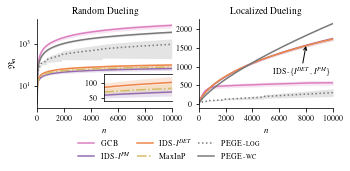

In [1043]:
# two per figure plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.8))


def exclude_fct(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if algorithm == 'IDS':
        if args.get('lls_beta') or args['ids_info'] == 'AsymptoticInfoGain':
            return True

    
def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
#     if algorithm == 'UCB' and args.get('lls_beta'):
#         styles['label'] = 'UCB-Tuned'
#         styles['linestyle'] = '-.'
    if algorithm == 'IDS':
        if args['ids_info'] == 'AsymptoticInfoGain':
            styles['color'] = COLORS[4]
        if args.get('lls_beta'):
            styles['label'] = styles['label'].replace('IDS', 'IDS-Tuned')
#         else:
        styles['linestyle'] = '-'
    return styles

 
lines = plot_regret(data_dueling_random, ax1,  exclude_fct=exclude_fct, style_fct=style_mod)

plot_regret(data_dueling_localized, ax2,  exclude_fct=exclude_fct, style_fct=style_mod)

for ax in (ax1, ax2):
#     ax.set_yscale('log')
    ax.set_xlim(0,10000)
    ax.set_xlabel(r'$n$')

ax1.set_title("Random Dueling")
ax2.set_title("Localized Dueling")
ax1.set_yscale('log')
ax1.set_ylabel(t_REGRET)

axins = ax1.inset_axes([0.5, 0.08, 0.5, 0.3])
axins.set_xticklabels([])
axins.set_xticks([])
axins.set_xlim(5000, 10000)
axins.set_ylim(40, 130)
plot_regret(data_dueling_random, axins,  exclude_fct=exclude_fct, style_fct=style_mod)


lgd = fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.4,-0.35),# Small spacing around legend box
           ncol=3,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )

set_figure_params()
hide_spines(ax1, ax2)
hide_spines(axins, left=False, top=False)
# fig.subplots_adjust()
fig.subplots_adjust(left=0.)


ax2.annotate(f"{t_IDS}-" + "\{" + fr"{t_IDET}, {t_IPM}" +"\}", xy=(8000,1600),  xytext=(5500, 750),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='bottom')

shift_axis(ax1a, -0.03)
# fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'pm', f"dueling.pdf",), bbox_inches='tight', pad_inches=0.00)

# Chapter 7

## Random Contextual

In [1044]:
basedir = '../..'
exp_name = "runs-thesis/7/contextual_simple_bandit_d4_k5_l3_v0.1-10000"
exp_name = "runs-thesis/7/contextual_simple_bandit_d4_k20_l5_v0.1-10000"

env, data_context, extra_data = load_data(exp_name, basedir=basedir)

Loaded 6 algorithms.


## Icecream

In [1045]:
basedir = '../..'
# exp_name = "runs-thesis/7/icecream_10-10000"
exp_name = "runs-thesis/7/icecream_5-10000"

env, data_icecream, extra_data = load_data(exp_name, basedir=basedir)

Loaded 12 algorithms.


IDS-9701166c32cf9b18e51a3f5a6f619a33
IDS-a013ee819aaa81a52079a70cbcd2764a
IDS-98a89550f46b74468a5b6194148bacff
IDS-e50fa6d0ebdcc3fac40dfad8eeafce0b
IDS-dcf89355ffbaebaf78ebe7886d9a62a5
IDS-0a7254854126ba2b07746c78c282e554
IDS-f8e885e1df7ee91489517904533317bc
IDS-8a2a4a4d57cf4e67960e913b9b4d1ecf
IDS-dd4a06fae5fbcbcdab61159bc631a3a2


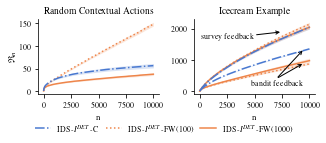

In [1046]:
# two per figure plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.5))
set_figure_params()


def exclude_fct(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
#     if algorithm == 'IDS':
#         if args.get('lls_beta') or args['ids_info'] == 'AsymptoticInfoGain':
#             return True


def exclude_fct_ice(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if algorithm == 'IDS':
        if not args.get('lls_beta'):
            return True
        
def exclude_fct_ctx(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if algorithm == 'IDS':
        if args.get('lls_beta'):
            return True
    
def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
    if args['ids_sampling'] == 'fast':
        styles['color'] = COLORS[0]
        styles['zorder'] = 10
        styles['label'] += f"-C"
    else:
        styles['label'] += f"-FW({args['ids_fw_steps']})"
        if args['ids_fw_steps'] == 1000:
            styles['linestyle'] = '-'
    return styles

 
lines = plot_regret(data_context, ax1,  exclude_fct=exclude_fct_ctx, style_fct=style_mod)
plot_regret(data_icecream, ax2,  exclude_fct=exclude_fct_ice, style_fct=style_mod)

for ax in (ax1, ax2):
    ax.set_xlabel('n')
ax1.set_title("Random Contextual Actions")
ax2.set_title("Icecream Example")
ax1.set_ylabel(t_REGRET)

handles, labels = ax1.get_legend_handles_labels()
handles = permute_list(handles, [1,0,2])
labels = permute_list(labels, [1,0,2])


lgd = fig.legend(handles,
           labels,
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.05),# Small spacing around legend box
           ncol=4,
           fancybox=False,
           frameon=False,
           columnspacing=1.,
          )
ax2.annotate(text='', xy=(9500,900), xytext=(7000,400), arrowprops=dict(arrowstyle='->'))
ax2.annotate(text='', xy=(9500,1350), xytext=(7000,400), arrowprops=dict(arrowstyle='->'))
ax2.text(7000, 180, 'bandit feedback', horizontalalignment='center')

ax2.annotate(text='', xy=(7500,1900), xytext=(5000,1800), arrowprops=dict(arrowstyle='->'))
ax2.text(4800, 1700, 'survey feedback', horizontalalignment='right')


hide_spines(ax1, ax2)
hide_spines( ax1a, left=True, right=False)
# fig.subplots_adjust()
fig.subplots_adjust(left=0.)

shift_axis(ax1a, -0.03)
fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, 'gallery', f"context.pdf",), bbox_inches='tight', pad_inches=0.00)

## Laser

In [1047]:
basedir = '../..'
# exp_name = "runs-thesis/7/icecream_10-10000"
exp_name = "runs-thesis/7/laser-10000"
env, data_laser, extra_data = load_data(exp_name, basedir=basedir)

exp_name = "runs-thesis/7/laser_indirect-10000"
env, data_laser_indirect, extra_data = load_data(exp_name, basedir=basedir)

Loaded 6 algorithms.
Loaded 5 algorithms.


IDS-333bbc54c6e3b831e9ec3cebbda997df
IDS-6c4a6879c525c0786da8ada03ff9e93e
UCB-ca0bd11fa57a862de7323cd35ae19d1c
IDS-583cca02aaf6f4eb422fba70c32e3096
IDS-c804cf5b88df80e06784a9066e9170a3
UCB-6049df9b1649dd2fc1857a1ce6363b3d


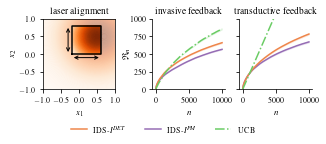

In [1048]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(TEXTWIDTH, TEXTWIDTH/2.6))
set_figure_params()

def make_laser_plot(axis):
    def f1(X1, X2):
        X1 = 1-X1
        return np.exp(-((X1-0.5)**2 + (X2 -0.5)**2))

    n = 100
    x1 = np.linspace(-1, 1, n)
    x2 = np.linspace(-1, 1, n)
    X1, X2 = np.meshgrid(x1, x2)
    Y = f1(X1,X2)


    x1_sub = np.linspace(-0.2, 0.6 , n)
    x2_sub = np.linspace(0.0, 0.8, n)
    X1_sub, X2_sub = np.meshgrid(x1_sub, x2_sub)
    Y_sub = f1(X1_sub,X2_sub)
    cmap = 'Oranges'
    cs = axis.contourf(X1, X2, Y, levels=100, antialiased=True, alpha=0.5, cmap=cmap)
    axis.contourf(X1_sub, X2_sub, Y_sub, alpha=1., levels=100, cmap=cmap)
    axis.plot([-0.2, 0.6, 0.6, -0.2, -0.2], [0., 0., 0.8, 0.8, 0], color='k')
    axis.annotate("", xy=(0.6, -0.1), xytext=(-0.2, -.1), arrowprops=dict(facecolor='black', lw=1, arrowstyle='<->'))
    axis.annotate("", xy=(-0.3, 0.), xytext=(-0.3, .8), arrowprops=dict(facecolor='black', lw=1, arrowstyle='<->'))


make_laser_plot(ax1)
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([-1,-.5, 0, 0.5, 1])
ax1.set_yticks([-1,-.5, 0, 0.5, 1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax1.set_title("laser alignment")



def exclude_fct(strategy_data):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    
def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
    styles['linestyle'] = '-'
    if algorithm == 'UCB':
        styles['linestyle'] = '-.'
#     if args.get('laser_indirect'):
#         styles['linestyle'] = '-.'
#     else:
#         styles['linestyle'] = '-'
#     if args['ids_sampling'] == 'fast':
#         styles['color'] = COLORS[0]
#         styles['zorder'] = 10
#         styles['label'] += f"-C"
#     else:
#         styles['label'] += f"-FW({args['ids_fw_steps']})"
#         if args['ids_fw_steps'] == 1000:
#             styles['linestyle'] = '-'
    return styles

 
lines = plot_regret(data_laser, ax2,  exclude_fct=exclude_fct, style_fct=style_mod)
lines = plot_regret(data_laser_indirect, ax3,  exclude_fct=exclude_fct, style_fct=style_mod)

for ax in (ax2, ax3):
    ax.set_xlabel(r'$n$')
    ax.set_ylim(0,10000)
ax2.set_ylabel(t_REGRET, labelpad=0)
hide_spines(ax2, ax3)

ax2.get_shared_y_axes().join(ax2, ax3)
ax2.set_ylim(0, 1000)
ax2.set_title('invasive feedback')
ax3.set_title('transductive feedback')
ax3.set_yticklabels([])

handles, labels = ax2.get_legend_handles_labels()
handles = permute_list(handles, [1,0,2])
labels = permute_list(labels, [1,0,2])


lgd = fig.legend(handles,
           labels,
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.1),# Small spacing around legend box
           ncol=4,
           fancybox=False,
           frameon=False,
           columnspacing=2.5,
          )

# lgd = fig.legend(lines,     # The line objects
#            labels=[l[0].get_label() for l in lines],   # The labels for each line
#            loc=('lower center'),   # Position of legend
#            borderaxespad=0. , 
#            bbox_to_anchor=(0.5,-0.3),# Small spacing around legend box
#            ncol=4,
#            fancybox=False,
#            frameon=False,
#            columnspacing=1.,
#           )
fig.tight_layout()
fig.subplots_adjust(wspace=0.35, hspace=0)
shift_axis(ax2, 0.035)

fig.savefig(os.path.join(PLOTDIR, 'gallery', f"laser.pdf",), bbox_inches='tight', pad_inches=0.00)

## Robust BO

In [1049]:
basedir = '../../runs-dueling/'
# exp_name = 'simple_bandit_v1.0-1000'
# exp_name = 'simple_bandit_v1.0_cNegativeDrift-1000'
# exp_name = 'simple_bandit_v1.0_cNegativeRepeat-1000'

drift = ['_cAutoCalibration', '_cPeriodicDrift']
# drift = '_cNegativeRepeat'
# drift = ''

experiments = []
noise = 'v0.1'
# noise = 'v1.0'

for d in drift:
    experiments.append(f'camelback_{noise}{d}-1000')

def sort_fct(data):
    strategy_data = data[1]
    label = strategy_data['algorithm']
    args = strategy_data['args']

    if label == 'DuelingIDS' or label == 'DuelingKernelIDS':
        if args.get('to_dueling') == 'one':
            return 1
        else:
            return 2
    if label == 'SemiparametricTS':
        return 4
    if label == 'UCB' or label == 'GPUCB':
        return 5
    if label == 'Bose':
        return 3
    if label == 'TS':
        return 6
    
    return 10
# read all experiments at once:
combined_data = []
for exp_name in experiments:
    combined_data.append(load_data(exp_name, basedir=basedir, sort_fct=sort_fct))


Loaded 9 algorithms.
Loaded 9 algorithms.


DuelingKernelIDS-37bd08bdcb4176e992e879d675cc6ce3
DuelingKernelIDS-760bf505035dc8f6107fd09c98342b53
GPUCB-e5184c1a304231a97112f2f302bed7a8
DuelingKernelIDS-d89d56bac34072d51e8b540cf399dc25
DuelingKernelIDS-fbee9c5b0bcf9f1a79cbf8a206b5e5ce
GPUCB-e30f96cc95089062d578d116147a4cf0


/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


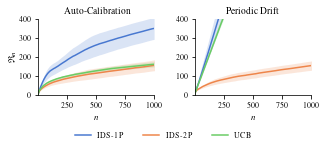

In [1050]:
# 2 x 2 ploth
fig, axes = plt.subplots(ncols=2, figsize=(TEXTWIDTH, TEXTWIDTH/2.5))

set_figure_params()

def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
    if algorithm == 'UCB':
        styles['label'] = t_GPUCB
    elif args.get('to_dueling') == 'one':
        styles['label'] =  r'\textsc{IDS-1P}'
        styles['color'] = COLORS[0]
    elif args.get('to_dueling') == 'two':
        styles['label'] = r'\textsc{IDS-2P}'
    return styles


def exclude_fct(strategy_data):
    """ exclude specific runs from plotting """
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if algorithm == 'TS':
        return True
    if args.get('beta') != 1.:
        return True
    return False

props = {
    f'camelback_{noise}_cPeriodicDrift': dict(
        title="Periodic Drift",
        ylim=400,
        ylabel=''
    ),
    f'camelback_{noise}_cAutoCalibration' : dict(
        title="Auto-Calibration",
        ylim=400,
        ylabel='Regret'
    ),
}
first = True
for ax, (env, data, _) in zip(axes, combined_data):
    hide_spines(ax)
    ax.set_title(props[env]['title'])
    
    ax.set_xlabel(r'$n$')
    ax.set_xlim(1,1000)
    ax.set_ylim(0, props[env]['ylim'])
    lines = plot_regret(data, ax, exclude_fct=exclude_fct, style_fct=style_mod, scale_fct=scale_fct)

axes[0].set_ylabel(t_REGRET)

# add legend
lgd = fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.1),# Small spacing around legend box
           ncol=3,
           fancybox=False,
           frameon=False,
           columnspacing=2.5,
          )

textargs = dict(
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=10
)
# fig.text(0.5, 0.5, 'End of Optimism', **textargs)
# fig.text(0.5, 1., 'Random Examples', **textargs)


fig.tight_layout()
# fig.subplots_adjust()
fig.subplots_adjust(wspace=0.35, hspace=0.5)
fig.savefig(os.path.join(PLOTDIR, 'gallery', f"robust-kernel.pdf",), bbox_inches='tight', pad_inches=0.00)

In [1051]:
basedir = '../../runs-dueling/'
# exp_name = 'simple_bandit_v1.0-1000'
# exp_name = 'simple_bandit_v1.0_cNegativeDrift-1000'
# exp_name = 'simple_bandit_v1.0_cNegativeRepeat-1000'

drift = ['', '_cNegativeRepeat', '_cNegativeDrift', '_cNegativeDrift_compensate']
drift = ['', '_cNegativeRepeat', '_cNegativeDrift_compensate']

# drift = '_cNegativeRepeat'
# drift = ''

experiments = []
for d in drift:
    experiments.append(f'simple_bandit_d4_k20_v1.0{d}-10000')

def sort_fct(data):
    strategy_data = data[1]
    label = strategy_data['algorithm']
    args = strategy_data['args']

    if label == 'DuelingIDS' or label == 'DuelingKernelIDS':
        if args.get('to_dueling') == 'one':
            return 1
        else:
            return 2
    if label == 'SemiparametricTS':
        return 4
    if label == 'UCB' or label == 'GPUCB':
        return 5
    if label == 'Bose':
        return 3
    if label == 'TS':
        return 6
    
    return 10

# read all experiments at once:
combined_data = []
for exp_name in experiments:
    combined_data.append(load_data(exp_name, basedir=basedir, sort_fct=sort_fct))

Loaded 7 algorithms.
Loaded 7 algorithms.
Loaded 7 algorithms.


DuelingIDS-5dd1ac7e23aae139f25b50afb7054502
DuelingIDS-d8b4d9f9789df55fb329f070846a3cc8
Bose-74858d421b718c96ffbd0ed6c3e1ed0c
SemiparametricTS-b2988d02481369b9a9895f285c8b7026
UCB-74cb0562c4d913ae76303d6fe6213c86
DuelingIDS-bed5cba5d80b2416e48e10cc0886df36
DuelingIDS-746e2995276815cc4726cd55069de878
Bose-8ad1d02ae39edf61da809ac52837c4ac
SemiparametricTS-7bd7af666f8e0834945ad2acac022208
UCB-a8cc70ad51f6b3f6a864dc06c33d96a8
DuelingIDS-bee0e7bb08ec1454622dfc5099046dfc
DuelingIDS-8504b01ec199c51e717f4aa6b9b6189e
Bose-71fdda17012225d7abfa01c5de46318d
SemiparametricTS-81c1261ab13bc97915a7587e1bdd9951
UCB-dcb8e51687da98cfb1b7e8db5d44a93f


/home/johannes/miniconda3/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


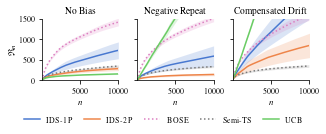

In [1052]:
fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(TEXTWIDTH, TEXTWIDTH/2.8))
## uncomment this line to transpose the plot:
# axes = list(map(list, zip(*axes))) # transpose axes array
# axes_flat = [a for aa in axes for a in aa]


def exclude_fct(strategy_data):
    """ exclude specific runs from plotting """
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    if algorithm.startswith('_'):
        return True
    if algorithm ==  'TS':
        return True
    return False

def style_mod(strategy_data, i):
    args = strategy_data['args']
    algorithm = strategy_data['algorithm']
    styles = style_fct(strategy_data, i)
#     if algorithm == 'UCB':
#         styles['label'] = t_GPUCB
    if args.get('to_dueling') == 'one':
        styles['label'] = r'\textsc{IDS-1P}'
        styles['color'] = COLORS[0]
    elif args.get('to_dueling') == 'two':
        styles['label'] =  r'\textsc{IDS-2P}'
    return styles



# some generic figure improvements
set_figure_params()

props = {
    'simple_bandit_d4_k20_v1.0': dict(
        title="No Bias",
        ylim=1500,
        ylabel=t_REGRET,
    ),
    'simple_bandit_d4_k20_v1.0_cNegativeRepeat' : dict(
        title="Negative Repeat",
        ylim=1500,
        ylabel=''
    ),
#    'simple_bandit_d4_k20_v1.0_cNegativeDrift': dict(
#         title="Drift",
#        ylim = 1000,
#        ylabel='Regret'
#    ),
    'simple_bandit_d4_k20_v1.0_cNegativeDrift_compensate': dict(
    title ="Compensated Drift",
        ylim=1500,
        ylabel=''
    )
}
first = True
for ax, (env, data, _) in zip(axes, combined_data):
    hide_spines(ax)
    ax.set_title(props[env]['title'])
    ax.set_ylabel(props[env]['ylabel'])
    

    ax.set_xlim(1,10000)
    ax.set_xlabel('$n$')
    ax.set_ylim(0, props[env]['ylim'])
    lines = plot_regret(data, ax, exclude_fct=exclude_fct, style_fct=style_mod, scale_fct=scale_fct)
#     ax.legend()
#     yl1, yl2 = props[env]['ylims']
#     if yl1 is not None:
#         ax1.set_ylim(*yl1)
    
#     # second plot (lines is used for the legend)
#     ax2.set_xscale('log')
#     lines = plot_regret(data, ax2, exclude=exclude_fct, label_fct=label_fct, line_fct=line_fct, color_fct=color_fct, n0=int(xl2[0]))
#     ax2.set_xlim(*xl2)
#     if yl2 is not None:
#         ax2.set_ylim(*yl2)

for ax in axes[1:]:
    ax.set_yticklabels([])
# add legend
lgd = fig.legend(lines,     # The line objects
           labels=[l[0].get_label() for l in lines],   # The labels for each line
           loc=('lower center'),   # Position of legend
           borderaxespad=0. , 
           bbox_to_anchor=(0.5,-0.1),# Small spacing around legend box
           ncol=5,
           fancybox=False,
           frameon=False,
           columnspacing=1.5,
          )

textargs = dict(
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=10
)
# fig.text(0.5, 0.5, 'End of Optimism', **textargs)
# fig.text(0.5, 1., 'Random Examples', **textargs)

fig.tight_layout()
# fig.subplots_adjust()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

fig.savefig(os.path.join(PLOTDIR, 'gallery', f"robust-linear.pdf",), bbox_inches='tight', pad_inches=0.00)